<h1><center>Recommendation On Fantasy League - ROFL</center></h1>

<img src="images/fantasy-premier-league-show.png">

# Introduction


Soccer is one of the most followed games in the world, and English Premier League(EPL) is highest earning, most competitive and most watched sports league. As soccer lovers, this experience extends beyond viewing the game and participating in Fantasy Premier Leagues and even betting, which may or may not include monetary transactions.
The popularity of FPL can be judged from the fact that more than 4 million people in Britain itself play the league annually.

Fantasy football is a game in which participants assemble an imaginary team of real life footballers and score points based on those players' actual statistical performance or their perceived contribution on the field of play. The fantasy football league ask participants to select 15 players within a price budget, with the combination of 2 goalkeepers, 5 defenders, 5 midfielders and 3 forwards. The game is run over 38 gameweeks, where each gameweek comprises of 10 matches of 20 teams. The aim of the game is to score as many points as possible. The scoring is done based on some factors, like, player appearance, goals scored, assists, clean sheets, penalties, wins. The scoring is adversely affected if goals are scored against the team, yellow or red card received, penalty misses, own goals and loss.

<img src="images/EPL-1.jpg"> 

## Motivation
As soccer fans and budding data scientists, we plan to tackle the problem of selecting players in an optimal and unbiased way. Most people, around the world, place bets based on emotions, expert advice or player popularity. At best, they consider past performances or statistics to find the optimal bet. We plan to build a recommender engine that ranks the players of different categories(Forward, Midfielder, Defender, Goalkeeper) and lets the user build his own team.

Our motivation of this project is to help soccer fans make informed decisions. Since our algorithms has no biases towards players, it helps bring relatively unknown players who are performing very well into limelight. This is due to the fact that we take into consideration unique features. 

<img src="images/img1.jpg"> 

# Related work

Current tools provide specific functionalities like customized transfer recommendations, points, projections, etc. using past statistics but most of them require a subscription.

Related work include Fantasy Football Fix(https://www.fantasyfootballfix.com/), which has features like predicting which players will change in value and when, showing player points projects based on past statistics. The work suffers from the drawback that the onus is on user to create his own team and try out different team combinations based on points predicted and optimizations suggested. 
Fantasy Football Geek(http://www.fantasyfootballgeek.co.uk/) and Scout(https://www.fantasyfootballscout.co.uk/) post news, tips and tricks, player rankings, game analysis, etc based on expert opinions but do not provide actual recommendations that our project aims to do.

Our project provides recommendations based on players data from recent and past performances. We provide recommendations on different categories, like top 10 attackers, defenders, midfielders and goalkeepers, which will help the user to build his own team. Unlike other subscription based solutions, we aim to make our project free for all soccer fans. By providing recommendations in each category, we provide a simplistic and easy to use solution for everyone. These differences certainly prove to be beneficial to users. 

<table><tr><td><img src='images/fantasyfix.png'></td><td><img src='images/fantasyfix2.png'></td></tr></table>

# Proposed solution


<img src="images/flow.png"> 

## Data Preprocessing


### Data collection, parsing, aggregation
1. Dataset for season 2016-17 has been obtained from https://github.com/vaastav/Fantasy-Premier-League/tree/master/data/2016-17. Current Season data is scraped from Fantasy Premier League website. Dataset includes both explicit and implicit features for each player. Explicit features are assists, goals scored, saves, passes completed, etc while implicit features cover player's bonus points, influence, creativity and threats. The dataset also covers player's past seasons history. Dataset for past season(2016-17) and (2017-18) contains gameweek wise scores and features for player. b 2. Player position and team data has been taken from FoxSports. 
3. Further, fixture table showing gameweek wise schedule of each match has been taken from Fantasy Premier League website.
Data from all the above sources has been merged together

In [4]:
import unicodedata
import pandas as pd
import glob

In [5]:
path = 'data/2016-17/players'
filenames = glob.glob(path + "/*/history.csv")
all_p_hData = (pd.read_csv(f, encoding='ISO-8859-1') for f in filenames)

# utf-8
player_history = pd.concat(all_p_hData, keys=[unicodedata.normalize('NFD', unicode(f[21:-12], "ISO-8859-1")).encode('ascii', 'ignore') for f in filenames])
#print player_history[:50]
player_data_df = player_history['total_points']


#print player_data_df

player_1617 = {} 
player_1718 = {}

for i, j in player_data_df.groupby(level = 0):
    mean_1718 = j[:].mean()
    mean_1617 = 0
    if len(j) > 1:
        mean_1617 = (j[:].sum() - j[len(j)-1])/float(len(j)-1)
        
    player_1617[i] = mean_1617
    player_1718[i] = mean_1718

    
player_1617_history_df = pd.DataFrame.from_dict(player_1617, orient='index', dtype=float)
player_1718_history_df = pd.DataFrame.from_dict(player_1718, orient='index', dtype=float)
player_1617_history_df[:5]

,0
Steven_Berghuis,13.000000
Ethan_Robson,0.000000
Christian_Fuchs,150.000000
Jan_Vertonghen,101.000000
Mamadou_Sakho,56.666667


### 2016-17 Training Data

In [6]:
path = 'data/2016-17/players'
filenames = glob.glob(path + "/*/gw.csv")

all_p_gwData = (pd.read_csv(f, index_col='round', encoding='ISO-8859-1') for f in filenames)
players_gw_1617_df = pd.concat(all_p_gwData, keys=[unicodedata.normalize('NFD', unicode(f[21:-7], "ISO-8859-1")).encode('ascii', 'ignore') for f in filenames])

#players_gw_1617_df


In [7]:
path = 'data/Player_Pos_Team_2016-17.csv'
pname_pos_team_1617_df = pd.read_csv(path, skiprows=None, encoding='utf-8')

fname1 = [unicodedata.normalize('NFD', x).encode('ascii', 'ignore') for x in pname_pos_team_1617_df['FirstName']]
sname1 = [unicodedata.normalize('NFD', x).encode('ascii', 'ignore') for x in pname_pos_team_1617_df['Surname']]
fname = pd.DataFrame({'name':fname1})
sname = pd.DataFrame({'name':sname1})

pname = fname + '_' + sname
pname_pos_team_1617_df['P_name'] = pname

player_pos_team = pname_pos_team_1617_df[['PositionsList', 'Team', 'P_name']].copy()
player_pos_team.set_index('P_name', inplace=True)
player_pos_team[:5]

,PositionsList,Team
P_name,,
Almen_Abdi,MID,Watford
Charlie_Adam,MID,Stoke
Albert_Adomah,MID,Middlesbrough
Adrian_San Miguel del Castillo,GLK,West Ham
Ibrahim_Afellay,MID,Stoke


In [8]:
for i,j in players_gw_1617_df.groupby(level=0):
    if i in player_pos_team.index:
        players_gw_1617_df.loc[i, 'position'] = player_pos_team.loc[i]['PositionsList']
        players_gw_1617_df.loc[i, 'team'] = player_pos_team.loc[i]['Team']    
    



In [9]:
team_ids_df = pd.read_csv('data/2016-17_Team_IDs.txt', index_col='ID')
for i in team_ids_df.index:
    team_name = team_ids_df.loc[i,'Team']
    players_gw_1617_df['opponent_team'].replace(to_replace=i, value=team_name, inplace=True)

#players_gw_1617_df['opponent_team']


### 2017-18 Data Preparation

In [10]:
path = 'data/2017-18/players'
filenames = glob.glob(path + "/*/gw.csv")

all_p_gwData = (pd.read_csv(f, index_col='round', encoding='ISO-8859-1') for f in filenames)
players_gw_1718_df = pd.concat(all_p_gwData, keys=[unicodedata.normalize('NFD', unicode(f[21:-7], "ISO-8859-1")).encode('ascii', 'ignore') for f in filenames])
players_gw_1718_df


# players_gw_1718_df = pd.DataFrame()
# list_ = []
# for file_ in filenames:
#     df = pd.read_csv(file_, encoding='ISO-8859-1')
#     #print type(df['round'][0])
#     df = df[df['round'] <= 30]
#     df.set_index('round', inplace=True)
#     list_.append(df)
# players_gw_1718_df = pd.concat(list_, keys=[unicodedata.normalize('NFD', unicode(f[21:-7], "ISO-8859-1")).encode('ascii', 'ignore') for f in filenames])
# players_gw_1718_df[:5]

# for name,j in players_gw_1718_df.groupby(level=0):
#     name = unicode(name, "ISO-8859-1")
#     name = unicodedata.normalize('NFD', name).encode('ascii', 'ignore')
    


# players_gw_1718_df.loc['Aaron_Cresswell']

assists  attempted_passes  big_chances_created  \
                   round                                                   
Aaron_Cresswell    1            0                10                    0   
                   2            0                21                    0   
                   3            0                43                    0   
                   4            0                22                    1   
                   5            0                30                    0   
                   6            0                44                    0   
                   7            0                40                    0   
                   8            0                25                    0   
                   9            0                 0                    0   
                   10           1                17                    1   
                   11           0                42                    0   
                   12           0                34                    0   
                   13           0                38                    0   
                   14           0                55                    0   
                   15           1                17                    0   
                   16           0                38                    0   
                   17           0                34                    0   
                   18           0                41                    0   
                   19           0                47                    0   
Aaron_Lennon       1            0                 0                    0   
                   2            0                 0                    0   
                   3            0                 2                    0   
                   4            0                 0                    0   
                   5            0                 0                    0   
                   6            0                 0                    0   
                   7            0                 0                    0   
                   8            0                 0                    0   
                   9            0                 0                    0   
                   10           0                18                    0   
                   11           1                 2                    0   
...                           ...               ...                  ...   
Zlatan_Ibrahimovic 9            0                 0                    0   
                   10           0                 0                    0   
                   11           0                 0                    0   
                   12           0                15                    0   
                   13           0                22                    0   
                   14           0                 6                    0   
                   15           0                 0                    0   
                   16           0                 4                    0   
                   17           0                 0                    0   
                   18           0                 0                    0   
                   19           0                 0                    0   
Alvaro_Morata      1            1                 5                    1   
                   2            0                18                    0   
                   3            1                18                    0   
                   4            0                19                    0   
                   5            0                20                    0   
                   6            0                25                    0   
                   7            0                 5                    0   
                   8            0                 0                    0   
                   9            0                21                    0  

In [11]:
path = 'data/Player_Pos_Team_2017-18.csv'
pname_pos_team_1718_df = pd.read_csv(path, skiprows=None, encoding='utf-8')

fname1 = [unicodedata.normalize('NFD', x).encode('ascii', 'ignore') for x in pname_pos_team_1718_df['FirstName']]
sname1 = [unicodedata.normalize('NFD', x).encode('ascii', 'ignore') for x in pname_pos_team_1718_df['Surname']]
fname = pd.DataFrame({'name':fname1})
sname = pd.DataFrame({'name':sname1})

pname = fname + '_' + sname
pname_pos_team_1718_df['P_name'] = pname

player_pos_team1 = pname_pos_team_1718_df[['PositionsList', 'Team', 'P_name']].copy()
player_pos_team1.set_index('P_name', inplace=True)
player_pos_team1[:5]

,PositionsList,Team
P_name,,
Rolando_Aarons,MID,Newcastle Utd
Tammy_Abraham,FWD,Swansea
Charlie_Adam,MID,Stoke
Adam_Smith,DEF,Bournemouth
Oluwatosin_Adarabioyo,DEF,Man City


In [12]:
for i,j in players_gw_1718_df.groupby(level=0):
    if i in player_pos_team1.index:
        players_gw_1718_df.loc[i, 'position'] = player_pos_team1.loc[i,'PositionsList']
        players_gw_1718_df.loc[i, 'team'] = player_pos_team1.loc[i]['Team']
        
# print players_gw_1718_df.loc['Aaron_Cresswell']

In [13]:
for i in team_ids_df.index:
    team_name = team_ids_df.loc[i,'Team']
    players_gw_1718_df['opponent_team'].replace(to_replace=i, value=team_name, inplace=True)

#players_gw_1718_df['opponent_team']

In [14]:
general_feature_cols = ['was_home', 'opponent_team']

X_train_gen_features_df = players_gw_1617_df.loc[:, general_feature_cols]
print X_train_gen_features_df.shape

Y_train_gen_features_df = players_gw_1617_df.loc[:, ['total_points']]
print Y_train_gen_features_df.shape

(23679, 2)
(23679, 1)


### Create X_Train and X_Test Data

1. First, data is splitted into training and testing. The model is trained on data from 2016-17 season. The data for each player is averaged for gameweek, such that each feature is averaged over all the gameweeks. 

2. In case of transfers, only those gameweeks are taken into consideration from which the player has entered the season. We test the data on 2017-18 season for each gameweek starting from gameweek 6. 

3. Our test data for a gameweek is the average of last five gameweeks, for example, for gameweek 6, the test data features are average of features of last 5 games. The player's past history feature is taken as average points over the seasons he has played prior to the season the model is trained/tested on.

4. The data is divided into 4 categories, for each position, namely, Goalkeeper, Forward, Defender, and Midfielder.

### TRAIN DATA

In [15]:
usecols = ['assists', 'attempted_passes', 'big_chances_created', 'big_chances_missed', 'bonus', 'bps', 'clean_sheets', 
'clearances_blocks_interceptions', 'completed_passes', 'creativity', 'dribbles', 'ea_index', 'errors_leading_to_goal', 'errors_leading_to_goal_attempt',
'fouls', 'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'key_passes', 'minutes', 'offside', 'open_play_crosses', 
'own_goals', 'penalties_conceded', 'penalties_missed', 'penalties_saved', 'recoveries', 'red_cards', 'saves', 'selected', 'tackled', 
'tackles', 'target_missed', 'threat', 'transfers_balance', 'total_points', 'history_points', 'value', 'yellow_cards']



In [16]:
players_gw_1617_df['history_points'] = 0



for i, j in players_gw_1617_df.groupby(level = 0):
    if i in player_1617_history_df.index:
        #print player_1617_history_df.loc[i,0]
        players_gw_1617_df.loc[i,'history_points'] = player_1617_history_df.loc[i,0]
        
#print players_gw_1617_df.loc['Aaron_Cresswell', 'history_points']      
        

In [17]:
players_gw_1718_df['history_points'] = 0



for i, j in players_gw_1718_df.groupby(level = 0):
    if i in player_1718_history_df.index:
        #print player_1617_history_df.loc[i,0]
        players_gw_1718_df.loc[i,'history_points'] = player_1718_history_df.loc[i,0]
        
#print players_gw_1718_df.loc['Aaron_Cresswell', 'history_points']      

In [18]:
X_train_players_glk_gw_df = players_gw_1617_df.loc[players_gw_1617_df['position'] == 'GLK']
X_train_players_def_gw_df = players_gw_1617_df.loc[players_gw_1617_df['position'] == 'DEF']
X_train_players_mid_gw_df = players_gw_1617_df.loc[players_gw_1617_df['position'] == 'MID']
X_train_players_fwd_gw_df = players_gw_1617_df.loc[players_gw_1617_df['position'] == 'FWD']
print X_train_players_glk_gw_df[usecols].groupby(level=0).mean().index


Index([u'Aaron_Ramsdale', u'Adam_Federici', u'Adrian_San Miguel del Castillo',
       u'Alexander_Manninger', u'Alex_McCarthy', u'Alex_Palmer',
       u'Allan_McGregor', u'Angus_Gunn', u'Artur_Boruc', u'Asmir_Begovic',
       u'Ben_Foster', u'Ben_Hamer', u'Boaz_Myhill', u'Bradley_Guzan',
       u'Claudio_Bravo', u'Costel_Pantilimon', u'Damian Emiliano_Martinez',
       u'Darren_Randolph', u'David_de Gea', u'David_Marshall', u'David_Ospina',
       u'Dimitrios_Konstantopoulos', u'Dusan_Kuciak',
       u'Eduardo_Dos Reis Carvalho', u'Eldin_Jakupovic', u'Fraser_Forster',
       u'Harry_Lewis', u'Heurelho_Gomes', u'Hugo_Lloris', u'Jack_Butland',
       u'Jack_Rose', u'Jakob_Haugaard', u'Joel Dinis_Castro Pereira',
       u'Joel_Robles', u'Joe_Hart', u'Jordan_Pickford', u'Julian_Speroni',
       u'Kasper_Schmeichel', u'Kieran_O'Hara', u'Kristoffer_Nordfeldt',
       u'Lee_Grant', u'Loris_Karius', u'Lukasz_Fabianski', u'Luke_McGee',
       u'Maarten_Stekelenburg', u'Maksymilian_Stryjek', u'M

In [19]:
X_train_players_glk_avg_df = X_train_players_glk_gw_df[usecols].groupby(level=0).mean()
X_train_players_def_avg_df = X_train_players_def_gw_df[usecols].groupby(level=0).mean()
X_train_players_mid_avg_df = X_train_players_mid_gw_df[usecols].groupby(level=0).mean()
X_train_players_fwd_avg_df = X_train_players_fwd_gw_df[usecols].groupby(level=0).mean()

In [20]:
n = 0
for i in X_train_players_def_avg_df.index:
    if i in player_pos_team.index:
        n += 1
        X_train_players_def_avg_df.loc[i, 'team'] = player_pos_team.loc[i]['Team']
print "DEF: ", n

n = 0
for i in X_train_players_fwd_avg_df.index:
    if i in player_pos_team.index:
        n += 1
        X_train_players_fwd_avg_df.loc[i, 'team'] = player_pos_team.loc[i]['Team']
print "FWD: ", n

n = 0
for i in X_train_players_glk_avg_df.index:
    if i in player_pos_team.index:
        n += 1
        X_train_players_glk_avg_df.loc[i, 'team'] = player_pos_team.loc[i]['Team']
print "GLK: ", n

n = 0
for i in X_train_players_mid_avg_df.index:
    if i in player_pos_team.index:
        n += 1
        X_train_players_mid_avg_df.loc[i, 'team'] = player_pos_team.loc[i]['Team']
print "MID: ", n

DEF:  210
FWD:  110
GLK:  69
MID:  279


In [21]:
Y_train_players_fwd_avg_df = X_train_players_fwd_avg_df.loc[:, X_train_players_fwd_avg_df.columns == 'total_points']
Y_train_players_def_avg_df = X_train_players_def_avg_df.loc[:, X_train_players_def_avg_df.columns == 'total_points']
Y_train_players_mid_avg_df = X_train_players_mid_avg_df.loc[:, X_train_players_mid_avg_df.columns == 'total_points']
Y_train_players_glk_avg_df = X_train_players_glk_avg_df.loc[:, X_train_players_glk_avg_df.columns == 'total_points']

X_train_players_fwd_avg_df = X_train_players_fwd_avg_df.loc[:, X_train_players_fwd_avg_df.columns != 'total_points']
X_train_players_def_avg_df = X_train_players_def_avg_df.loc[:, X_train_players_def_avg_df.columns != 'total_points']
X_train_players_mid_avg_df = X_train_players_mid_avg_df.loc[:, X_train_players_mid_avg_df.columns != 'total_points']
X_train_players_glk_avg_df = X_train_players_glk_avg_df.loc[:, X_train_players_glk_avg_df.columns != 'total_points']

### TEST DATA

In [108]:
X_test_df = players_gw_1718_df.copy()
# count = 0
for i,j in X_test_df.groupby(level=0):
    gw_list = [x[1] for x in list(j.index)]
    for gw, row in j.iterrows():
        X_test_df.loc[(gw[0], gw[1]), usecols] = 0.0
        if(gw[1] > 5):
#             if(count > 1):
#                 break
            if((gw[1]-1) in gw_list):
                X_test_df.loc[(gw[0], gw[1]), usecols] += (players_gw_1718_df.loc[(gw[0], gw[1]-1), usecols])
            if((gw[1]-2) in gw_list):
                X_test_df.loc[(gw[0], gw[1]), usecols] += (players_gw_1718_df.loc[(gw[0], gw[1]-2), usecols])
            if((gw[1]-3) in gw_list):
                X_test_df.loc[(gw[0], gw[1]),usecols] += (players_gw_1718_df.loc[(gw[0], gw[1]-3), usecols])
            if((gw[1]-4) in gw_list):
                X_test_df.loc[(gw[0], gw[1]), usecols] += (players_gw_1718_df.loc[(gw[0], gw[1]-4), usecols])
            if((gw[1]-5) in gw_list):
                X_test_df.loc[(gw[0], gw[1]), usecols] += (players_gw_1718_df.loc[(gw[0], gw[1]-5), usecols])
            #print X_test_df.loc[gw, usecols]
            X_test_df.loc[gw,usecols] = X_test_df.loc[gw,usecols].div(5, axis=0)
            #X_test_df.loc[gw] = X_test_df/5
            #print X_test_df.loc[gw]
            
            #count += 1
        #print j.loc[(gw[0], gw[1])]
#     if count > 1:
#         break

#print players_gw_1718_df.iloc[:, players_gw_1718_df.groupby(level == 0) == 'Aaron_Cresswell']
# print players_gw_1718_df.loc[('Aaron_Cresswell',20)]

In [109]:
%store X_test_df

Stored 'X_test_df' (DataFrame)


In [27]:
%store -r

In [28]:
usecols.extend(['position', 'team'])
X_test_df_temp = X_test_df[usecols]

X_test_players_glk_gw_df = X_test_df_temp.loc[X_test_df_temp['position'] == 'GLK']
X_test_players_def_gw_df = X_test_df_temp.loc[X_test_df_temp['position'] == 'DEF']
X_test_players_mid_gw_df = X_test_df_temp.loc[X_test_df_temp['position'] == 'MID']
X_test_players_fwd_gw_df = X_test_df_temp.loc[X_test_df_temp['position'] == 'FWD']

print X_test_players_fwd_gw_df.shape
print X_test_players_def_gw_df.shape
print X_test_players_glk_gw_df.shape
print X_test_players_mid_gw_df.shape

(1463, 42)
(3530, 42)
(1124, 42)
(4446, 42)


In [29]:
Y_test_players_fwd_gw_df = players_gw_1718_df.loc[players_gw_1718_df['position'] == 'FWD']
Y_test_players_fwd_gw_df = Y_test_players_fwd_gw_df.loc[:, Y_test_players_fwd_gw_df.columns == 'total_points']

In [30]:
Y_test_players_fwd_gw_df[:5]

total_points
                    round              
Aleksandar_Mitrovic 1                 0
                    2                 0
                    3                 5
                    4                 0
                    5                 0

In [31]:
Y_test_players_def_gw_df = players_gw_1718_df.loc[players_gw_1718_df['position'] == 'DEF']
Y_test_players_def_gw_df = Y_test_players_def_gw_df.loc[:, Y_test_players_def_gw_df.columns == 'total_points']

Y_test_players_mid_gw_df = players_gw_1718_df.loc[players_gw_1718_df['position'] == 'MID']
Y_test_players_mid_gw_df = Y_test_players_mid_gw_df.loc[:, Y_test_players_mid_gw_df.columns == 'total_points']

Y_test_players_glk_gw_df = players_gw_1718_df.loc[players_gw_1718_df['position'] == 'GLK']
Y_test_players_glk_gw_df = Y_test_players_glk_gw_df.loc[:, Y_test_players_glk_gw_df.columns == 'total_points']

In [32]:
X_test_players_fwd_gw_df = X_test_players_fwd_gw_df.loc[:, X_test_players_fwd_gw_df.columns != 'total_points']
X_test_players_def_gw_df = X_test_players_def_gw_df.loc[:, X_test_players_def_gw_df.columns != 'total_points']
X_test_players_mid_gw_df = X_test_players_mid_gw_df.loc[:, X_test_players_mid_gw_df.columns != 'total_points']
X_test_players_glk_gw_df = X_test_players_glk_gw_df.loc[:, X_test_players_glk_gw_df.columns != 'total_points']

In [33]:
X_train_players_glk_avg_df.drop('team', axis=1, inplace=True)
#print X_train_players_glk_avg_df.columns

In [34]:
X_test_players_glk_gw_df.drop(['team', 'position'], axis=1, inplace=True)
X_train_players_def_avg_df.drop('team', axis=1, inplace=True)
X_test_players_def_gw_df.drop(['team', 'position'], axis=1, inplace=True)
X_train_players_fwd_avg_df.drop('team', axis=1, inplace=True)
X_test_players_fwd_gw_df.drop(['team', 'position'], axis=1, inplace=True)
X_train_players_mid_avg_df.drop('team', axis=1, inplace=True)
X_test_players_mid_gw_df.drop(['team', 'position'], axis=1, inplace=True)

In [35]:
print X_test_players_glk_gw_df.shape

(1124, 39)


# Training model and Prediction

1. For predicting player performance, we look at his current trend. Player's current trend is defined as average performance over the last 5 games. Next, we look at player's past performance over past seasons. Then, performance is evaluated both for implicit and explicit features and their combination.

2. We have tried various models to rank the players and predict their performance, namely Linear Regression, Bayesian Ridge Regression, SVR, and Ranking SVM. The regression models just predict the total_points of the player and rank them in decreasing order in each category. Ranking SVM computes pairwise comparision of players, and for each combination of players, assigns a score of +1 or -1, depending upon who is better among the two. The final score is computed based on the number of wins for each player, and the score is sorted to obtain the top players.

3. The players are ranked in each category and top 10 players in each category are recommended to the users.

# Training model definition:

In [36]:
from sklearn import linear_model
from sklearn.svm import SVR

def linear_regression(X_train_df, Y_train_df, X_test_df, Y_test_df, num=10):
    regr = linear_model.LinearRegression()
    regr.fit(X_train_df, Y_train_df)
    
    Y_pred_df = Y_test_df.copy()
    Y_pred_df['total_points'] = regr.predict(X_test_df)
    
    return calculate_precision(Y_test_df, Y_pred_df, num)




def svm_model(X_train_df, Y_train_df, X_test_df, Y_test_df, num=10):
    clf = SVR(C=1.0, epsilon=0.2)
    clf.fit(X_train_df, Y_train_df)

    Y_pred_df = Y_test_df.copy()
    Y_pred_df['total_points'] = clf.predict(X_test_df)
    
    return calculate_precision(Y_test_df, Y_pred_df, num)




def bayesian_ridge(X_train_df, Y_train_df, X_test_df, Y_test_df, num=10):
    clf2 = linear_model.BayesianRidge()
    clf2.fit(X_train_df, Y_train_df)
    
    Y_pred_df = Y_test_df.copy()
    Y_pred_df['total_points'] = clf2.predict(X_test_df)
    
    return calculate_precision(Y_test_df, Y_pred_df, num)




def neural_network(X_train_df, Y_train_df, X_test_df, Y_test_df, num=10):
    clf3 = neural_network.MLPRegressor(
    hidden_layer_sizes=(10,),  activation='relu', solver='adam', alpha=0.001, batch_size='auto',
    learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
    random_state=9, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
    early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    
    clf3.fit(X_train_df, Y_train_df)
    
    Y_pred_df = Y_test_df.copy()
    Y_pred_df['total_points'] = clf2.predict(X_test_df)
    
    return calculate_precision(Y_test_df, Y_pred_df, num)


In [37]:
import itertools
import numpy as np

from sklearn import svm, linear_model #, cross_validation


def transform_pairwise(X, y):
    X_new = []
    y_new = []
    y = np.asarray(y)
    if y.ndim == 1:
        y = np.c_[y, np.ones(y.shape[0])]
    comb = itertools.combinations(range(X.shape[0]), 2)
    comb_actual = []
    for k, (i, j) in enumerate(comb):
        # print(y[i], "   ", y[j])
        if y[i, 0] == y[j, 0]:
            # skip if same target or different group
            continue
        X_new.append(X[i] - X[j])
        y_new.append(np.sign(y[i, 0] - y[j, 0]))
        # output balanced classes
        if y_new[-1] != (-1) ** k:
            y_new[-1] = - y_new[-1]
            X_new[-1] = - X_new[-1]
        comb_actual.append([i,j])
    return np.asarray(X_new), np.asarray(y_new).ravel(), comb_actual


class RankSVM(svm.LinearSVC):
    """Performs pairwise ranking with an underlying LinearSVC model
    Input should be a n-class ranking problem, this object will convert it
    into a two-class classification problem, a setting known as
    `pairwise ranking`.
    See object :ref:`svm.LinearSVC` for a full description of parameters.
    """

    def fit(self, X, y):
        X_trans, y_trans, comb = transform_pairwise(X, y)
        super(RankSVM, self).fit(X_trans, y_trans)
        return self

    def predict(self, X):
        if hasattr(self, 'coef_'):
            np.argsort(np.dot(X, self.coef_.T))
        else:
            raise ValueError("Must call fit() prior to predict()")

    def score(self, X, y):
        X_trans, y_trans, comb = transform_pairwise(X, y)
        return np.mean(super(RankSVM, self).predict(X_trans) == y_trans), super(RankSVM, self).predict(X_trans), y_trans, comb



In [38]:
import os

def apply_ranking_svm(X_train_df, Y_train_df, X_test_df, Y_test_df, num=10):
    X_train_temp = X_train_df.copy()
    X_test_temp = X_test_df.copy()

    X = X_train_temp.as_matrix()
    Y = np.array(Y_train_df)
    
    gw_prec_score = {}
    Y_pred_df = Y_test_df.copy()
    Y_pred_df['total_points'] = 0
    
    gw_top_players = {}
    
    rank_svm = RankSVM().fit(X, Y)
    for j in range(6,20):
        Y_test = (Y_test_df.groupby(level=1)).get_group(j).as_matrix()
        X_test = (X_test_temp.groupby(level=1)).get_group(j).as_matrix()

        #print y
        
        score, y_pred, y_test, comb = rank_svm.score(X_test, Y_test)
        #print score

        Y_pred = (Y_pred_df.groupby(level=1)).get_group(j)
        Y_true_df = (Y_test_df.groupby(level=1)).get_group(j)
        #Y_pred['total_points'] = 0


        for counter, value in enumerate(comb):
            if y_pred[counter] == 1:
                Y_pred.iloc[value[0]]['total_points'] += 1
                #print Y_pred_df.loc(Y_pred.iloc[value[0]])
                #Y_pred_fwd.iloc[value[1]]['total_points'] -= 1
            else:
                #Y_pred_fwd.iloc[value[0]]['total_points'] -= 1
                Y_pred.iloc[value[1]]['total_points'] += 1

        gw_prec_score[j] = calculate_precision_one_gw(Y_true_df, Y_pred, num) 
        y_pred_group = Y_pred.sort_values(by=['total_points'], ascending=False)[:num]
        player_list = []
        for i in y_pred_group.iterrows():
            player_list.append([i[0][0], i[1][0]])

        gw_top_players[j] = player_list
        #if j == 6:
#         Y_pred_df = (Y_pred_df.add(Y_pred, axis='rows')).fillna(0)
#         #print Y_pred_df
#         if j == 19:
#             print Y_pred_df

        
        
    return gw_prec_score, gw_top_players


## Evaluation Metrics, Precision definition:

In [39]:

def calculate_precision(y_true_df, y_pred_df, num=10):
    gw_prec_score = {}
    
    for j in range(6,20):
        
        y_true_gw_df = (y_true_df.groupby(level=1)).get_group(j)
        y_pred_gw_df = (y_pred_df.groupby(level=1)).get_group(j)
        
        score = calculate_precision_one_gw(y_true_gw_df, y_pred_gw_df, num)
        
#         y_true_group = (y_true_df.groupby(level=1)).get_group(j).sort_values(by=['total_points'], ascending=False)[:num]
#         y_pred_group = (y_pred_df.groupby(level=1)).get_group(j).sort_values(by=['total_points'], ascending=False)[:num]

#         y_true_list = []
#         for i in y_true_group.iterrows():
#             y_true_list.append([i[0][0]])

#         count = 0
#         for i in y_pred_group.iterrows():
#             if [i[0][0]] in y_true_list:
#                 count += 1

        gw_prec_score[j] = score

    return gw_prec_score


def calculate_precision_one_gw(Y_true_df, Y_pred_df, num=10):
    y_true_group = Y_true_df.sort_values(by=['total_points'], ascending=False)[:num]
    y_pred_group = Y_pred_df.sort_values(by=['total_points'], ascending=False)[:num]

    #print y_true_group
    #print y_pred_group
    
    y_true_list = []
    for i in y_true_group.iterrows():
        y_true_list.append([i[0][0]])

    count = 0
    for i in y_pred_group.iterrows():
        if [i[0][0]] in y_true_list:
            count += 1

    gw_prec_score = count/float(num)
    return gw_prec_score
    
    
    
def calculate_precision_for_last_gw(y_true_df, y_pred_df, num=10):
    gw_prec_score = {}
    
    for j in range(6,20):
        
        y_true_gw_df = (y_true_df.groupby(level=1)).get_group(19)
        y_pred_gw_df = (y_pred_df.groupby(level=1)).get_group(j)
        
        score = calculate_precision_one_gw(y_true_gw_df, y_pred_gw_df, num)
        
#         y_true_group = (y_true_df.groupby(level=1)).get_group(j).sort_values(by=['total_points'], ascending=False)[:num]
#         y_pred_group = (y_pred_df.groupby(level=1)).get_group(j).sort_values(by=['total_points'], ascending=False)[:num]

#         y_true_list = []
#         for i in y_true_group.iterrows():
#             y_true_list.append([i[0][0]])

#         count = 0
#         for i in y_pred_group.iterrows():
#             if [i[0][0]] in y_true_list:
#                 count += 1

        gw_prec_score[j] = score

    return gw_prec_score


# Test all models for all positions:

## Defining all features, explicit, implicit, and past history

### Selecting Features
Based upon game analysis and point score as given by Fantasy Premier League website, we came up with a set of features for each category of players. We divide our data into set of explicit, implicit and global history features.
1. Explicit Features are features that can directly be calculated from the gameplay. These include bunch of positive and negative features for each player: 
    For forwards, features such as assists, goals_scored, tackled, missed penalties.
    For midfielders, assists, big_chances_created, completed_passes, dribbles, goals_scored, key_passes
    Defender: clean_sheets, clearances_blocks_interceptions, own_goals 
    Goalkeeper: Saves, clean_sheets.
    Furthur, some features like minutes, fouls are taken for every position of players.

2. Implicit features are subjective features that are calculated by Fantasy Premier League website. This include bonus points given to each player based on his performance. Also, features such as player influence, creativity and threat are some of implicit features

3. Player past history is taken into account as global feature. This feature selects players based on past performances only.

In [40]:
fwd_features = ['assists', 'big_chances_missed', 'dribbles', 'penalties_missed',
                'goals_scored', 'minutes', 'tackled', 
                'target_missed']

mid_features = ['assists', 'big_chances_created', 'completed_passes', 'dribbles', 'fouls', 
                'goals_scored', 'key_passes', 'minutes', 'open_play_crosses', 
                'tackled', 'value']

def_features = ['clean_sheets', 'clearances_blocks_interceptions',
               'errors_leading_to_goal',
               'goals_conceded', 'minutes', 'own_goals', 'tackles']

glk_features = ['clean_sheets',
               'fouls', 'goals_conceded', 'minutes', 'own_goals', 'penalties_conceded',
               'penalties_saved', 'saves', 'value']



fwd_implicit_features = ['bonus', 'bps', 'creativity', 'threat']
mid_implicit_features = ['bonus', 'creativity', 'threat']
def_implicit_features = ['bonus', 'bps', 'influence']
glk_implicit_features = ['bonus', 'bps', 'influence']

past_history_features = ['history_points']


In [41]:
from sklearn import preprocessing
normalizer = preprocessing.Normalizer()


def get_X_train_X_test_from_features_fwd(features):
    X_train_players_fwd_avg_temp_df = X_train_players_fwd_avg_df[features]
    X_test_players_fwd_gw_temp_df = X_test_players_fwd_gw_df[features]
    X_train_players_fwd_avg_norm_df = X_train_players_fwd_avg_temp_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    X_test_players_fwd_gw_norm_df = X_test_players_fwd_gw_temp_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    return X_train_players_fwd_avg_norm_df, X_test_players_fwd_gw_norm_df
    
    
def get_X_train_X_test_from_features_mid(features):
    X_train_players_mid_avg_temp_df = X_train_players_mid_avg_df[features]
    X_test_players_mid_gw_temp_df = X_test_players_mid_gw_df[features]
    X_train_players_mid_avg_norm_df = X_train_players_mid_avg_temp_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    X_test_players_mid_gw_norm_df = X_test_players_mid_gw_temp_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    return X_train_players_mid_avg_norm_df, X_test_players_mid_gw_norm_df



def get_X_train_X_test_from_features_def(features):
    X_train_players_def_avg_temp_df = X_train_players_def_avg_df[features]
    X_test_players_def_gw_temp_df = X_test_players_def_gw_df[features]
    X_train_players_def_avg_norm_df = X_train_players_def_avg_temp_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    X_test_players_def_gw_norm_df = X_test_players_def_gw_temp_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    return X_train_players_def_avg_norm_df, X_test_players_def_gw_norm_df
    
    
def get_X_train_X_test_from_features_glk(features):
    X_train_players_glk_avg_temp_df = X_train_players_glk_avg_df[features]
    X_test_players_glk_gw_temp_df = X_test_players_glk_gw_df[features]
    X_train_players_glk_avg_norm_df = X_train_players_glk_avg_temp_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    X_test_players_glk_gw_norm_df = X_test_players_glk_gw_temp_df.apply(lambda x: (x - x.min()) / (x.max() - x.min()))
    return X_train_players_glk_avg_norm_df, X_test_players_glk_gw_norm_df



## Functions to obtain results for different positions:

In [42]:

def get_forward_results(features):
    
    X_train, X_test = get_X_train_X_test_from_features_fwd(features)
    
    fwd_lin_precision = linear_regression(X_train, Y_train_players_fwd_avg_df, 
                                      X_test, Y_test_players_fwd_gw_df)
    #print "Linear regression: ", fwd_lin_precision

    fwd_svm_precision = svm_model(X_train, Y_train_players_fwd_avg_df, 
                                      X_test, Y_test_players_fwd_gw_df)
    #print "SVM: ", fwd_svm_precision

    fwd_bayesridge_precision = bayesian_ridge(X_train, Y_train_players_fwd_avg_df, 
                                      X_test, Y_test_players_fwd_gw_df)

    #print "Bayesian Ridge Regression: ", fwd_bayesridge_precision


    fwd_svm_rank_precision, Y_pred_df = apply_ranking_svm(X_train, Y_train_players_fwd_avg_df, 
                                      X_test, Y_test_players_fwd_gw_df)

    #print "Ranking SVM: ", fwd_svm_rank_precision
    
    return fwd_lin_precision, fwd_svm_precision, fwd_bayesridge_precision, fwd_svm_rank_precision
    # fwd_neural_precision = neural_network(X_train_players_fwd_avg_df, Y_train_players_fwd_avg_df, 
    #                                   X_test_players_fwd_gw_df, Y_test_players_fwd_gw_df)

    # print "Neural Networks: ", fwd_neural_precision

    
    
def get_defender_results(features):
    
    X_train, X_test = get_X_train_X_test_from_features_def(features)
    
    def_lin_precision = linear_regression(X_train, Y_train_players_def_avg_df, 
                                      X_test, Y_test_players_def_gw_df)
    #print "Linear regression: ", fwd_lin_precision

    def_svm_precision = svm_model(X_train, Y_train_players_def_avg_df, 
                                      X_test, Y_test_players_def_gw_df)
    #print "SVM: ", fwd_svm_precision

    def_bayesridge_precision = bayesian_ridge(X_train, Y_train_players_def_avg_df, 
                                      X_test, Y_test_players_def_gw_df)

    #print "Bayesian Ridge Regression: ", fwd_bayesridge_precision


    def_svm_rank_precision, Y_pred_df = apply_ranking_svm(X_train, Y_train_players_def_avg_df, 
                                      X_test, Y_test_players_def_gw_df)

    #print "Ranking SVM: ", fwd_svm_rank_precision
    
    return def_lin_precision, def_svm_precision, def_bayesridge_precision, def_svm_rank_precision
    # fwd_neural_precision = neural_network(X_train_players_fwd_avg_df, Y_train_players_fwd_avg_df, 
    #                                   X_test_players_fwd_gw_df, Y_test_players_fwd_gw_df)

    # print "Neural Networks: ", fwd_neural_precision

    
    
def get_midfielder_results(features):
    
    X_train, X_test = get_X_train_X_test_from_features_mid(features)
    
    mid_lin_precision = linear_regression(X_train, Y_train_players_mid_avg_df, 
                                      X_test, Y_test_players_mid_gw_df)
    #print "Linear regression: ", fwd_lin_precision

    mid_svm_precision = svm_model(X_train, Y_train_players_mid_avg_df, 
                                      X_test, Y_test_players_mid_gw_df)
    #print "SVM: ", fwd_svm_precision

    mid_bayesridge_precision = bayesian_ridge(X_train, Y_train_players_mid_avg_df, 
                                      X_test, Y_test_players_mid_gw_df)

    #print "Bayesian Ridge Regression: ", fwd_bayesridge_precision


    mid_svm_rank_precision, Y_pred_df = apply_ranking_svm(X_train, Y_train_players_mid_avg_df, 
                                      X_test, Y_test_players_mid_gw_df)

    #print "Ranking SVM: ", fwd_svm_rank_precision
    
    return mid_lin_precision, mid_svm_precision, mid_bayesridge_precision, mid_svm_rank_precision
    # fwd_neural_precision = neural_network(X_train_players_fwd_avg_df, Y_train_players_fwd_avg_df, 
    #                                   X_test_players_fwd_gw_df, Y_test_players_fwd_gw_df)

    # print "Neural Networks: ", fwd_neural_precision

    
def get_goalkeeper_results(features):
    
    X_train, X_test = get_X_train_X_test_from_features_glk(features)
    #X_train.fillna(0, inplace=True)
    X_test.fillna(0, inplace=True)
    #Y_train_players_glk_avg_df.fillna(0)
    #Y_test_players_glk_gw_df.fillna(0)
    
    glk_lin_precision = linear_regression(X_train, Y_train_players_glk_avg_df, 
                                      X_test, Y_test_players_glk_gw_df)
    #print "Linear regression: ", fwd_lin_precision

    glk_svm_precision = svm_model(X_train, Y_train_players_glk_avg_df, 
                                      X_test, Y_test_players_glk_gw_df)
    #print "SVM: ", fwd_svm_precision

    glk_bayesridge_precision = bayesian_ridge(X_train, Y_train_players_glk_avg_df, 
                                      X_test, Y_test_players_glk_gw_df)

    #print "Bayesian Ridge Regression: ", fwd_bayesridge_precision


    glk_svm_rank_precision, Y_pred_df = apply_ranking_svm(X_train, Y_train_players_glk_avg_df, 
                                      X_test, Y_test_players_glk_gw_df)

    #print "Ranking SVM: ", fwd_svm_rank_precision
    
    return glk_lin_precision, glk_svm_precision, glk_bayesridge_precision, glk_svm_rank_precision
    # fwd_neural_precision = neural_network(X_train_players_fwd_avg_df, Y_train_players_fwd_avg_df, 
    #                                   X_test_players_fwd_gw_df, Y_test_players_fwd_gw_df)

    # print "Neural Networks: ", fwd_neural_precision



# Evaluation and analysis 
1. Results on different models:
We ran 4 models on all four positions to rank players for each gameweek. Four models are Linear Regression, Bayesian Ridge Regression, SVR and Ranking SVM. Ranking SVM outperformed all other methods(Regression, Bayesian Ridge, and SVR) showing that for ranking, pairwise comparison is always better and scoring based on regression models.

2. Evaluation metrics - precision:
We use precision for top 10 players. Our predicted top 10 players in each category is compared against the actual top 10 players for that gameweek.

3. Analysis:
We furthur analysed the effect of implicit, explicit and global factors on player performance prediction. We observed that player current trend is the most important feature in predicting performance for the next gameweek. Implicit features such as ict_index offer little advantage, boosting the performance by 0.1.


## Forward:

In [43]:

lin_fw_f1, svr_fw_f1, bayes_ridge_fw_f1, svm_rank_fw_f1 = get_forward_results(fwd_features)

print lin_fw_f1
print svr_fw_f1
print svm_rank_fw_f1

C:\Users\TUSHAR\AppData\Local\conda\conda\envs\cs670\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{6: 0.4, 7: 0.3, 8: 0.1, 9: 0.4, 10: 0.4, 11: 0.4, 12: 0.3, 13: 0.2, 14: 0.4, 15: 0.3, 16: 0.2, 17: 0.3, 18: 0.3, 19: 0.3}
{6: 0.4, 7: 0.3, 8: 0.2, 9: 0.4, 10: 0.3, 11: 0.3, 12: 0.4, 13: 0.2, 14: 0.4, 15: 0.2, 16: 0.1, 17: 0.4, 18: 0.3, 19: 0.4}
{6: 0.6, 7: 0.7, 8: 0.6, 9: 0.2, 10: 0.7, 11: 0.6, 12: 0.5, 13: 0.7, 14: 0.4, 15: 0.6, 16: 0.5, 17: 0.7, 18: 0.7, 19: 0.7}


In [44]:
lin_fw_f2, svr_fw_f2, bayes_ridge_fw_f2, svm_rank_fw_f2 = get_forward_results(fwd_features +past_history_features)

print lin_fw_f2
print svr_fw_f2
print svm_rank_fw_f2

{6: 0.4, 7: 0.3, 8: 0.1, 9: 0.4, 10: 0.4, 11: 0.4, 12: 0.3, 13: 0.2, 14: 0.4, 15: 0.3, 16: 0.2, 17: 0.3, 18: 0.3, 19: 0.3}
{6: 0.4, 7: 0.3, 8: 0.2, 9: 0.4, 10: 0.2, 11: 0.3, 12: 0.4, 13: 0.2, 14: 0.4, 15: 0.2, 16: 0.1, 17: 0.4, 18: 0.3, 19: 0.4}
{6: 0.5, 7: 0.8, 8: 0.6, 9: 0.2, 10: 0.7, 11: 0.7, 12: 0.6, 13: 0.6, 14: 0.4, 15: 0.6, 16: 0.5, 17: 0.7, 18: 0.7, 19: 0.7}


In [45]:
lin_fw_f3, svr_fw_f3, bayes_ridge_fw_f3, svm_rank_fw_f3 = get_forward_results(fwd_features + fwd_implicit_features +past_history_features)

print lin_fw_f3
print svr_fw_f3
print svm_rank_fw_f3

{6: 0.4, 7: 0.3, 8: 0.1, 9: 0.4, 10: 0.3, 11: 0.4, 12: 0.3, 13: 0.2, 14: 0.4, 15: 0.3, 16: 0.2, 17: 0.2, 18: 0.2, 19: 0.3}
{6: 0.4, 7: 0.3, 8: 0.2, 9: 0.4, 10: 0.3, 11: 0.3, 12: 0.4, 13: 0.3, 14: 0.3, 15: 0.2, 16: 0.1, 17: 0.4, 18: 0.3, 19: 0.3}
{6: 0.5, 7: 0.7, 8: 0.7, 9: 0.4, 10: 0.7, 11: 0.7, 12: 0.7, 13: 0.6, 14: 0.5, 15: 0.7, 16: 0.5, 17: 0.7, 18: 0.7, 19: 0.6}


In [46]:
lin_fw_f4, svr_fw_f4, bayes_ridge_fw_f4, svm_rank_fw_f4 = get_forward_results(fwd_features + fwd_implicit_features)

print lin_fw_f4
print svr_fw_f4
print svm_rank_fw_f4

{6: 0.4, 7: 0.3, 8: 0.1, 9: 0.4, 10: 0.3, 11: 0.4, 12: 0.3, 13: 0.2, 14: 0.4, 15: 0.3, 16: 0.2, 17: 0.2, 18: 0.2, 19: 0.3}
{6: 0.4, 7: 0.3, 8: 0.2, 9: 0.4, 10: 0.3, 11: 0.3, 12: 0.4, 13: 0.3, 14: 0.3, 15: 0.2, 16: 0.1, 17: 0.4, 18: 0.3, 19: 0.3}
{6: 0.4, 7: 0.7, 8: 0.6, 9: 0.4, 10: 0.7, 11: 0.6, 12: 0.7, 13: 0.6, 14: 0.4, 15: 0.6, 16: 0.5, 17: 0.7, 18: 0.6, 19: 0.6}


In [47]:
import matplotlib.pyplot as plt

gw = range(6,20)

plt.plot(gw, lin_fw_f3.values(), 'r', label='Linear Regression')
plt.plot(gw, svm_rank_fw_f3.values(), 'b', label='SVM Rank')
plt.plot(gw, svr_fw_f3.values(), 'k', label='SVR')
#plt.plot(gw, svm_rank_f3.values(), 'g', label='+Past History + Implicit') 
#svm_rank = np.array([svm_rank_fw_f1.values(), svm_rank_f2.values(), svm_rank_f3.values(),  svm_rank_f4.values()])
#svm_rank = np.average(svm_rank, axis=0)
#plt.plot(gw, svm_rank, 'b', label='Mean')

plt.ylabel('Precision Score')
plt.xlabel('Gameweek')
plt.legend(loc='lower right')
plt.title('Forward Position Precision Scores')
plt.ylim(0,0.8)
#plt.show()
#plt.savefig('forward_precision_features_1.png', transparent=True)
plt.savefig('forward_comparison_reg_svmrank.png')

In [48]:
plt.plot(gw, svm_rank_fw_f1.values(), 'r', label='Explicit')
plt.plot(gw, svm_rank_fw_f2.values(), 'b', label='+Past History')
plt.plot(gw, svm_rank_fw_f3.values(), 'k', label='+Implicit+Past History')
#plt.plot(gw, svm_rank_f3.values(), 'g', label='+Past History + Implicit') 
#svm_rank = np.array([svm_rank_fw_f1.values(), svm_rank_f2.values(), svm_rank_f3.values(),  svm_rank_f4.values()])
#svm_rank = np.average(svm_rank, axis=0)
#plt.plot(gw, svm_rank, 'b', label='Mean')

plt.ylabel('Precision Score')
plt.xlabel('Gameweek')
plt.legend(loc='lower right')
plt.title('Forward Position Precision Scores')
plt.ylim(0,1)
#plt.show()
plt.savefig('forward_explicit_factors.png', transparent=True)

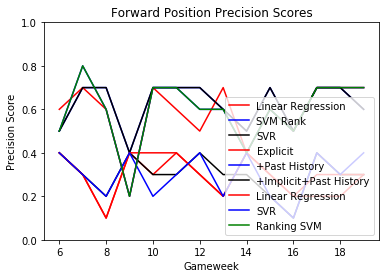

In [49]:
gw = range(6,20)

plt.plot(gw, lin_fw_f2.values(), 'r', label='Linear Regression')
plt.plot(gw, svr_fw_f2.values(), 'b', label='SVR')  
plt.plot(gw, svm_rank_fw_f2.values(), 'g', label='Ranking SVM') 
plt.ylabel('Precision Score')
plt.xlabel('Gameweek')
plt.legend(loc='lower right')
plt.title('Forward Position Precision Scores')
plt.ylim(0,1)
plt.show()
plt.savefig('forward_precision.png', transparent=True)

# Defender:

In [50]:

lin_def_f1, svr_def_f1, bayes_ridge_def_f1, svm_rank_def_f1 = get_defender_results(def_features)

print lin_def_f1
print svr_def_f1
print svm_rank_def_f1

# def_neural_precision = neural_network(X_train_players_def_avg_df, Y_train_players_def_avg_df, 
#                                   X_test_players_def_gw_df, Y_test_players_def_gw_df)

# print "Neural Networks: ", def_neural_precision


{6: 0.2, 7: 0.2, 8: 0.1, 9: 0.2, 10: 0.2, 11: 0.1, 12: 0.2, 13: 0.1, 14: 0.0, 15: 0.0, 16: 0.1, 17: 0.2, 18: 0.3, 19: 0.0}
{6: 0.2, 7: 0.1, 8: 0.1, 9: 0.3, 10: 0.2, 11: 0.0, 12: 0.1, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.2, 18: 0.2, 19: 0.0}
{6: 0.2, 7: 0.3, 8: 0.5, 9: 0.5, 10: 0.5, 11: 0.4, 12: 0.4, 13: 0.5, 14: 0.4, 15: 0.4, 16: 0.4, 17: 0.1, 18: 0.2, 19: 0.7}


In [51]:
lin_def_f2, svr_def_f2, bayes_ridge_def_f2, svm_rank_def_f2 = get_defender_results(def_features +past_history_features)

print lin_def_f2
print svr_def_f2
print svm_rank_def_f2

{6: 0.1, 7: 0.2, 8: 0.1, 9: 0.3, 10: 0.2, 11: 0.1, 12: 0.2, 13: 0.1, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.2, 18: 0.3, 19: 0.0}
{6: 0.2, 7: 0.1, 8: 0.2, 9: 0.3, 10: 0.2, 11: 0.1, 12: 0.1, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.2, 18: 0.3, 19: 0.0}
{6: 0.1, 7: 0.3, 8: 0.6, 9: 0.4, 10: 0.4, 11: 0.4, 12: 0.3, 13: 0.4, 14: 0.6, 15: 0.4, 16: 0.4, 17: 0.2, 18: 0.3, 19: 0.6}


In [52]:
lin_def_def_f3, svr_def_f3, bayes_ridge_def_f3, svm_rank_def_f3 = get_defender_results(def_features + def_implicit_features +past_history_features)

print lin_def_def_f3
print svr_def_f3
print svm_rank_def_f3

{6: 0.1, 7: 0.1, 8: 0.2, 9: 0.3, 10: 0.2, 11: 0.1, 12: 0.0, 13: 0.1, 14: 0.1, 15: 0.0, 16: 0.0, 17: 0.2, 18: 0.3, 19: 0.1}
{6: 0.2, 7: 0.2, 8: 0.2, 9: 0.3, 10: 0.1, 11: 0.2, 12: 0.1, 13: 0.1, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.2, 18: 0.2, 19: 0.1}
{6: 0.1, 7: 0.4, 8: 0.4, 9: 0.4, 10: 0.5, 11: 0.5, 12: 0.2, 13: 0.6, 14: 0.4, 15: 0.1, 16: 0.3, 17: 0.0, 18: 0.3, 19: 0.6}


In [53]:
lin_def_def_f4, svr_def_f4, bayes_ridge_def_f4, svm_rank_def_f4 = get_defender_results(def_features + def_implicit_features)

print lin_def_def_f4
print svr_def_f4
print svm_rank_def_f4

{6: 0.1, 7: 0.1, 8: 0.2, 9: 0.3, 10: 0.2, 11: 0.1, 12: 0.0, 13: 0.1, 14: 0.1, 15: 0.0, 16: 0.0, 17: 0.2, 18: 0.3, 19: 0.1}
{6: 0.2, 7: 0.1, 8: 0.2, 9: 0.2, 10: 0.1, 11: 0.2, 12: 0.1, 13: 0.0, 14: 0.0, 15: 0.0, 16: 0.0, 17: 0.2, 18: 0.2, 19: 0.1}
{6: 0.2, 7: 0.4, 8: 0.4, 9: 0.5, 10: 0.6, 11: 0.5, 12: 0.3, 13: 0.5, 14: 0.4, 15: 0.1, 16: 0.3, 17: 0.0, 18: 0.4, 19: 0.5}


In [54]:
gw = range(6,20)


plt.plot(gw, svm_rank_def_f1.values(), 'r', label='Explicit')
plt.plot(gw, svm_rank_def_f2.values(), 'b', label='+Past History')
# plt.plot(gw, svm_rank_def_f3.values(), 'k', label='+Implicit+Past History')
# plt.plot(gw, svm_rank_def_f4.values(), 'g', label='Implicit') 
#svm_rank = np.array([svm_rank_f1.values(), svm_rank_f2.values(), svm_rank_def_f3.values(),  svm_rank_def_f4.values()])
#svm_rank = np.average(svm_rank, axis=0)
#plt.plot(gw, svm_rank, 'b', label='Mean')

plt.ylabel('Precision Score')
plt.xlabel('Gameweek')
plt.legend(loc='lower right')
plt.title('Defender Position Precision Scores')
plt.ylim(0,1)
#plt.show()
plt.savefig('defender_features.png')


In [55]:
plt.plot(gw, lin_def_f2.values(), 'r', label='Linear Regression')
plt.plot(gw, svr_def_f2.values(), 'b', label='SVR')  
plt.plot(gw, svm_rank_def_f2.values(), 'g', label='Ranking SVM') 
plt.ylabel('Precision Score')
plt.xlabel('Gameweek')
plt.legend(loc='lower right')
plt.title('Defender Position Precision Scores')
plt.ylim(0,0.8)
#plt.show()
plt.savefig('defender_models.png')

# Goalkeeper:

In [56]:

lin_glk_f1, svr_glk_f1, bayes_ridge_glk_f1, svm_rank_glk_f1 = get_goalkeeper_results(glk_features)

print lin_glk_f1
print svr_glk_f1
print svm_rank_glk_f1


{6: 0.5, 7: 0.5, 8: 0.5, 9: 0.4, 10: 0.4, 11: 0.5, 12: 0.5, 13: 0.7, 14: 0.3, 15: 0.2, 16: 0.5, 17: 0.4, 18: 0.5, 19: 0.5}
{6: 0.4, 7: 0.5, 8: 0.6, 9: 0.4, 10: 0.4, 11: 0.5, 12: 0.6, 13: 0.6, 14: 0.4, 15: 0.1, 16: 0.5, 17: 0.3, 18: 0.6, 19: 0.5}
{6: 0.5, 7: 0.5, 8: 0.5, 9: 0.3, 10: 0.8, 11: 0.5, 12: 0.5, 13: 0.7, 14: 0.6, 15: 0.8, 16: 0.9, 17: 0.8, 18: 0.7, 19: 0.4}


In [57]:

lin_glk_f2, svr_glk_f2, bayes_ridge_glk_f2, svm_rank_glk_f2 = get_goalkeeper_results(glk_features +past_history_features)

print lin_glk_f2
print svr_glk_f2
print svm_rank_glk_f2

{6: 0.5, 7: 0.5, 8: 0.5, 9: 0.4, 10: 0.4, 11: 0.5, 12: 0.5, 13: 0.7, 14: 0.3, 15: 0.2, 16: 0.5, 17: 0.4, 18: 0.5, 19: 0.5}
{6: 0.4, 7: 0.5, 8: 0.6, 9: 0.3, 10: 0.4, 11: 0.5, 12: 0.5, 13: 0.7, 14: 0.4, 15: 0.1, 16: 0.4, 17: 0.4, 18: 0.6, 19: 0.5}
{6: 0.5, 7: 0.5, 8: 0.5, 9: 0.3, 10: 0.8, 11: 0.4, 12: 0.7, 13: 0.7, 14: 0.6, 15: 0.7, 16: 0.9, 17: 0.7, 18: 0.6, 19: 0.5}


In [58]:


lin_glk_f3, svr_glk_f3, bayes_ridge_glk_f3, svm_rank_glk_f3 = get_goalkeeper_results(glk_features + glk_implicit_features +past_history_features)

print lin_glk_f3
print svr_glk_f3
print svm_rank_glk_f3

{6: 0.4, 7: 0.5, 8: 0.4, 9: 0.5, 10: 0.4, 11: 0.5, 12: 0.5, 13: 0.7, 14: 0.4, 15: 0.2, 16: 0.5, 17: 0.4, 18: 0.5, 19: 0.4}
{6: 0.5, 7: 0.5, 8: 0.6, 9: 0.4, 10: 0.4, 11: 0.5, 12: 0.5, 13: 0.7, 14: 0.4, 15: 0.1, 16: 0.5, 17: 0.4, 18: 0.6, 19: 0.5}
{6: 0.5, 7: 0.4, 8: 0.5, 9: 0.4, 10: 0.8, 11: 0.5, 12: 0.6, 13: 0.7, 14: 0.6, 15: 0.7, 16: 1.0, 17: 0.9, 18: 0.7, 19: 0.4}


In [59]:

lin_glk_f4, svr_glk_f4, bayes_ridge_glk_f4, svm_rank_glk_f4 = get_goalkeeper_results(glk_features + glk_implicit_features)

print lin_glk_f4
print svr_glk_f4
print svm_rank_glk_f4

{6: 0.4, 7: 0.5, 8: 0.4, 9: 0.5, 10: 0.4, 11: 0.5, 12: 0.5, 13: 0.7, 14: 0.4, 15: 0.2, 16: 0.5, 17: 0.4, 18: 0.5, 19: 0.4}
{6: 0.5, 7: 0.4, 8: 0.5, 9: 0.4, 10: 0.4, 11: 0.5, 12: 0.5, 13: 0.7, 14: 0.4, 15: 0.2, 16: 0.5, 17: 0.4, 18: 0.6, 19: 0.5}
{6: 0.5, 7: 0.4, 8: 0.5, 9: 0.4, 10: 0.8, 11: 0.5, 12: 0.6, 13: 0.7, 14: 0.7, 15: 0.8, 16: 0.9, 17: 0.8, 18: 0.5, 19: 0.4}


In [60]:
plt.plot(gw, svm_rank_glk_f1.values(), 'r', label='Explicit')
# plt.plot(gw, svm_rank_glk_f2.values(), 'b', label='+Past History')
# plt.plot(gw, svm_rank_glk_f4.values(), 'k', label='+Implicit')
plt.plot(gw, svm_rank_glk_f3.values(), 'g', label='+Past History + Implicit') 
#svm_rank = np.array([svm_rank_glk_f1.values(), svm_rank_glk_f2.values(), svm_rank_glk_f3.values(),  svm_rank_glk_f4.values()])
#svm_rank = np.average(svm_rank, axis=0)
#plt.plot(gw, svm_rank, 'b', label='Mean')

plt.ylabel('Precision Score')
plt.xlabel('Gameweek')
plt.legend(loc='lower right')
plt.title('Goalkeeper Position Precision Scores')
plt.ylim(0,1)
# plt.show()
plt.savefig('goalkeeper_features.png')

In [61]:
plt.plot(gw, lin_glk_f2.values(), 'r', label='Linear Regression')
plt.plot(gw, svr_glk_f2.values(), 'b', label='SVR')  
plt.plot(gw, svm_rank_glk_f2.values(), 'g', label='Ranking SVM') 
plt.ylabel('Precision Score')
plt.xlabel('Gameweek')
plt.legend(loc='lower right')
plt.title('Goalkeeper Position Precision Scores')
plt.ylim(0,1)
# plt.show()
plt.savefig('goalkeeper_models.png')

# Midfielder:

In [62]:

lin_mid_f1, svr_mid_f1, bayes_ridge_mid_f1, svm_rank_mid_f1 = get_midfielder_results(mid_features)

print lin_mid_f1
print svr_mid_f1
print svm_rank_mid_f1



lin_mid_f2, svr_mid_f2, bayes_ridge_mid_f2, svm_rank_mid_f2 = get_midfielder_results(mid_features +past_history_features)

print lin_mid_f2
print svr_mid_f2
print svm_rank_mid_f2



lin_mid_f3, svr_mid_f3, bayes_ridge_mid_f3, svm_rank_mid_f3 = get_midfielder_results(mid_features + mid_implicit_features +past_history_features)

print lin_mid_f3
print svr_mid_f3
print svm_rank_mid_f3


lin_mid_f4, svr_mid_f4, bayes_ridge_mid_f4, svm_rank_mid_f4 = get_midfielder_results(mid_features + mid_implicit_features)

print lin_mid_f4
print svr_mid_f4
print svm_rank_mid_f4




{6: 0.2, 7: 0.1, 8: 0.3, 9: 0.1, 10: 0.1, 11: 0.3, 12: 0.1, 13: 0.2, 14: 0.4, 15: 0.1, 16: 0.1, 17: 0.1, 18: 0.4, 19: 0.3}
{6: 0.3, 7: 0.2, 8: 0.3, 9: 0.2, 10: 0.1, 11: 0.3, 12: 0.3, 13: 0.2, 14: 0.4, 15: 0.1, 16: 0.1, 17: 0.2, 18: 0.3, 19: 0.3}
{6: 0.5, 7: 0.5, 8: 0.2, 9: 0.3, 10: 0.3, 11: 0.6, 12: 0.2, 13: 0.6, 14: 0.3, 15: 0.4, 16: 0.4, 17: 0.7, 18: 0.4, 19: 0.4}
{6: 0.2, 7: 0.1, 8: 0.3, 9: 0.1, 10: 0.1, 11: 0.3, 12: 0.1, 13: 0.2, 14: 0.4, 15: 0.1, 16: 0.1, 17: 0.1, 18: 0.4, 19: 0.3}
{6: 0.3, 7: 0.1, 8: 0.3, 9: 0.2, 10: 0.1, 11: 0.2, 12: 0.2, 13: 0.2, 14: 0.4, 15: 0.1, 16: 0.1, 17: 0.2, 18: 0.3, 19: 0.3}
{6: 0.5, 7: 0.5, 8: 0.2, 9: 0.3, 10: 0.2, 11: 0.6, 12: 0.2, 13: 0.5, 14: 0.3, 15: 0.3, 16: 0.4, 17: 0.7, 18: 0.4, 19: 0.4}
{6: 0.2, 7: 0.1, 8: 0.3, 9: 0.1, 10: 0.1, 11: 0.3, 12: 0.1, 13: 0.2, 14: 0.3, 15: 0.1, 16: 0.1, 17: 0.2, 18: 0.4, 19: 0.3}
{6: 0.3, 7: 0.2, 8: 0.2, 9: 0.1, 10: 0.1, 11: 0.2, 12: 0.2, 13: 0.2, 14: 0.4, 15: 0.1, 16: 0.1, 17: 0.3, 18: 0.3, 19: 0.3}
{6: 0.4, 7: 0.5,

In [63]:
plt.plot(gw, svm_rank_mid_f1.values(), 'r', label='Explicit')
plt.plot(gw, svm_rank_mid_f2.values(), 'b', label='+Past History')
# plt.plot(gw, svm_rank_mid_f4.values(), 'k', label='+Implicit')
plt.plot(gw, svm_rank_mid_f3.values(), 'g', label='+Past History + Implicit') 
#svm_rank = np.array([svm_rank_f1.values(), svm_rank_f2.values(), svm_rank_f3.values(),  svm_rank_f4.values()])
#svm_rank = np.average(svm_rank, axis=0)
#plt.plot(gw, svm_rank, 'b', label='Mean')

plt.ylabel('Precision Score')
plt.xlabel('Gameweek')
plt.legend(loc='lower right')
plt.title('Midfielder Position Precision Scores')
plt.ylim(0,0.8)
#plt.show()
plt.savefig('midfielder_features.png')

In [64]:
plt.plot(gw, lin_mid_f3.values(), 'r', label='Linear Regression')
plt.plot(gw, svr_mid_f3.values(), 'b', label='SVR')  
plt.plot(gw, svm_rank_mid_f3.values(), 'g', label='Ranking SVM') 
plt.ylabel('Precision Score')
plt.xlabel('Gameweek')
plt.legend(loc='lower right')
plt.title('Midfielder Position Precision Scores')
plt.ylim(0,0.8)
#plt.show()
plt.savefig('midfielder_models.png')

## Result and Discussion:
We observe that:
1. Ranking SVM outperformed all other factors by a significant amount, reaching 0.9 precision in some gameweeks.
2. Player's past history gives a slight improvement over only current trend, giving more score to players who are currently not in form but have been phenomenal in the past.
3. Implicit factors give slight improvement over explicit, though not over all gameweeks.

<img src="images/resultsweek6.png">

## Key Takeaways - 

1. Ranking svm performed better as compared to regression and svr it computes pairwise performance.
2. Player past performance improves performance slightly. If a good player is not performing in recent games, still due to his past performance, he will not lose all points.

# Conclusions

Challenges:
1. Fantasy premier league website only provides the current data of the players. Extracting the data for past seasons was quite challenging. Any single source of data didn't suffice, due to which we had to extract data from multiple sources providing information of different Features for players like Teams and Positions.
2. Player name different and contained special characters, had to be handled. 
3. Understanding and tuning features for each category of players, for example, for forward position we considered features like goals scored and assists as most important features. Features like ict index, which is a combination of player's influence, creativity and threat also play a major role in player ranking.


In future, our model can be extended to provide complete manager module, which can recommend optimal players in case of:
1. Substitutions - In the game which three players can be substituted to optimize the team
2. Injuries - In case of injuries, who is the most "similar" player to replace the injured player
3. Transfers - which player(s) from other teams can be bought to improve the team performance in the future season

Also, in future we plan to use neural models and deep learning to learn hidden features and analyse their effects on precision of results.

Open issues:
1. Dataset is only available for 2016-17 season, for better results more data is required.

2. Since we are predicting the player features to be the average of his last 5 games, if a player is not even participating even in a gameweek, our model still gives points to the player assuming the player will appear in the game, leading to inaccurate results. Somehow, the model needs to know whether the player would play or not in the next gameweek.

3. The model does not consider any injuries, suspensions the player might have, and gives results assuming that the players who started in the season continue to play the entire season. Although since our algorithm takes into account player's current trend, if a player is not playing continuously for last games, automatically his predicted performance decreases.


# Ethical Issues -

1. This tool, though not intended to, but may indirectly encourage people to gamble.
2. destroy the spirit of this beautiful game. This tool stands to provide a better recommendation for substitutions than existing recommendations available on Fantasy Premier League site and in no way effect the spirit of the sports.
3. While the tool aims to have no biases towards player performances, it tends to select players based on recent performances and their data, which is detrimental to new players.

# Form Team

<img src = "images/teamrec.png">

We also provide team recommendation to user modelling the problem as a linear programming one. We give 2 goalkeepers, 5 midfielders, 5 defenders, and 3 forwards, picking a total of 15 players for the gameweek asked by the user under a certain budget, which is 1000 by default. 

Along with the above constraints, we take more constraints such as no more than 3 players can be from the same team. We use a LPU solver and put all the constraints as optimization equations. From all the equations, we recommend a team of 15 players as per the above combination to the user.

Reference : http://www.philipkalinda.com/ds9.html

In [65]:
#player_cost_df = pd.read_csv('data/player_cost.csv')
X_train, X_test = get_X_train_X_test_from_features_fwd(fwd_features + past_history_features)
    
fwd_svm_rank_precision, gw_fwd_playerslist = apply_ranking_svm(X_train, Y_train_players_fwd_avg_df, 
                                                      X_test, Y_test_players_fwd_gw_df)

In [66]:
fwd_svm_rank_precision

{6: 0.5,
 7: 0.8,
 8: 0.6,
 9: 0.2,
 10: 0.7,
 11: 0.7,
 12: 0.6,
 13: 0.6,
 14: 0.4,
 15: 0.6,
 16: 0.5,
 17: 0.7,
 18: 0.7,
 19: 0.7}

In [67]:
print gw_fwd_playerslist[6]

[['Troy_Deeney', 42], ['Javier_Hernandez Balcazar', 42], ['Daniel_Sturridge', 40], ['Tomer_Hemed', 39], ['Sergio_Aguero', 39], ['Joshua_King', 38], ['Andre_Gray', 38], ['Shane_Long', 37], ['Alvaro_Morata', 37], ['Charlie_Austin', 36]]


In [68]:
X_train, X_test = get_X_train_X_test_from_features_mid(mid_features + mid_implicit_features + past_history_features)
    
mid_svm_rank_precision, gw_mid_playerslist = apply_ranking_svm(X_train, Y_train_players_mid_avg_df, 
                                                      X_test, Y_test_players_mid_gw_df)



X_train, X_test = get_X_train_X_test_from_features_def(def_features + def_implicit_features + past_history_features)
    
def_svm_rank_precision, gw_def_playerslist = apply_ranking_svm(X_train, Y_train_players_def_avg_df, 
                                                      X_test, Y_test_players_def_gw_df)


X_train, X_test = get_X_train_X_test_from_features_glk(glk_features + glk_implicit_features + past_history_features)
X_test.fillna(0, inplace=True)
glk_svm_rank_precision, gw_glk_playerslist = apply_ranking_svm(X_train, Y_train_players_glk_avg_df, 
                                                      X_test, Y_test_players_glk_gw_df)

In [69]:
for i in gw_fwd_playerslist.keys():
    outFile = open('data/results/fw/' + str(i) + '_fw.txt', 'w')
    for j in gw_fwd_playerslist[i]:
        outFile.write("%s\n" % j[0])
    outFile.close()

for i in gw_mid_playerslist.keys():
    outFile = open('data/results/mid/' + str(i) + '_mid.txt', 'w')
    for j in gw_mid_playerslist[i]:
        outFile.write("%s\n" % j[0])
    outFile.close()
        
for i in gw_def_playerslist.keys():
    outFile = open('data/results/def/' + str(i) + '_def.txt', 'w')
    for j in gw_def_playerslist[i]:
        outFile.write("%s\n" % j[0])
    outFile.close()
        
for i in gw_glk_playerslist.keys():
    outFile = open('data/results/glk/' + str(i) + '_glk.txt', 'w')
    for j in gw_glk_playerslist[i]:
        outFile.write("%s\n" % j[0])
    outFile.close()

In [140]:
# def_df = pd.DataFrame(gw_def_playerslist[6])
# def_df.columns = ['Name', 'Points']
# def_df['Position'] = 'DEF'
# print def_df 

In [141]:
# df = pd.concat([def_df, mid_df], axis=0)
# df.reindex()

# df = def_df.append(mid_df, ignore_index=True)
# print X_test_df.loc[(df.loc[0,'Name'],6)]['value']

In [178]:
# print X_test_df.loc[('Aaron_Cresswell',6)]['value']




In [191]:
gw = 6
avail_cash = 1000
avail_gk = 2
avail_def = 5
avail_mid = 5
avail_fwd = 3

from pulp import *

#def form_team_gw(i):

prob = pulp.LpProblem('FantasyTeam', pulp.LpMaximize)


#global prob

decision_variables = []

mid_df = pd.DataFrame(gw_mid_playerslist[gw])
mid_df.columns = ['Name', 'Points']
mid_df['Position'] = 'MID'

def_df = pd.DataFrame(gw_def_playerslist[gw])
def_df.columns = ['Name', 'Points']
def_df['Position'] = 'DEF'

fwd_df = pd.DataFrame(gw_fwd_playerslist[gw])
fwd_df.columns = ['Name', 'Points']
fwd_df['Position'] = 'FWD'

glk_df = pd.DataFrame(gw_glk_playerslist[gw])
glk_df.columns = ['Name', 'Points']
glk_df['Position'] = 'GLK'

players_df = mid_df.append(def_df, ignore_index=True)
players_df = players_df.append(fwd_df, ignore_index=True)
players_df = players_df.append(glk_df, ignore_index=True)

players_df['Cost'] = 0.0
players_df['Team'] = "ARS"



#add cost, team of the player
for index, row in players_df.iterrows():
    #print X_test_df.loc[(index, i)]['value']
    players_df.loc[index,'Cost'] = players_gw_1718_df.loc[(players_df.loc[index,'Name'], gw-1)]['value']
    #print players_df.loc[index,'Cost']
    players_df.loc[index,'Team'] = X_test_df.loc[(players_df.loc[index,'Name'], gw)]['team']

# print players_df

for rownum, row in players_df.iterrows():
    variable = str('x' + str(rownum))
    variable = pulp.LpVariable(str(variable), lowBound = 0, upBound = 1, cat= 'Integer') #make variables binary
    decision_variables.append(variable)


print ("Total number of decision_variables: " + str(len(decision_variables)))


total_points = ""
for rownum, row in players_df.iterrows():
    #print rownum
    for i, player in enumerate(decision_variables):
        #print i, player
        if rownum == i:
            formula = row['Cost']*player
            total_points += formula
            #print total_points

prob += total_points
# print ("Optimization function: " + str(total_points))


total_paid = ""
for rownum, row in players_df.iterrows():

    for i, player in enumerate(decision_variables):
        if rownum == i:
            formula = row['Cost']*player
            total_paid += formula

prob += (total_paid <= avail_cash)

# print prob



total_gk = ""
for rownum, row in players_df.iterrows():
    for i, player in enumerate(decision_variables):
        if rownum == i:
            if row['Position'] == 'GLK':
                formula = 1*player
                total_gk += formula
prob += (total_gk == avail_gk)
# print(total_gk)


total_def = ""
for rownum, row in players_df.iterrows():
    for i, player in enumerate(decision_variables):
        if rownum == i:
            if row['Position'] == 'DEF':
                formula = 1*player
                total_def += formula
prob += (total_def == avail_def)
# print((total_def))



total_mid = ""
for rownum, row in players_df.iterrows():
    for i, player in enumerate(decision_variables):
        if rownum == i:
            if row['Position'] == 'MID':
                formula = 1*player
                total_mid += formula
prob += (total_mid == avail_mid)
#print((total_mid))




total_fwd = ""
for rownum, row in players_df.iterrows():
    for i, player in enumerate(decision_variables):
        if rownum == i:
            if row['Position'] == 'FWD':
                formula = 1*player
                total_fwd += formula
prob += (total_fwd == avail_fwd)
#print(total_fwd)


team_dict= {}
for team in set(players_df['Team']):
    team_dict[str(team)]=dict()
    team_dict[str(team)]['avail'] = 3
    team_dict[str(team)]['total'] = ""
    for rownum, row in players_df.iterrows():
        for i, player in enumerate(decision_variables):
            if rownum == i:
                if row['Team'] == team:
                    formula = 1*player
                    team_dict[str(team)]['total'] += formula

    prob += (team_dict[str(team)]['total'] <= team_dict[str(team)]['avail'])
#print(len(team_dict))


#print prob


prob.writeLP('FantasyTeam.lp')
optimization_result = prob.solve()
assert optimization_result == pulp.LpStatusOptimal
print("Status:", LpStatus[prob.status])
print("Optimal Solution to the problem: ", value(prob.objective))
print ("Individual decision_variables: ")
for v in prob.variables():
    print(v.name, "=", v.varValue)




variable_name = []
variable_value = []

for v in prob.variables():
    variable_name.append(v.name)
    variable_value.append(v.varValue)

df = pd.DataFrame({'variable': variable_name, 'value': variable_value})
for rownum, row in df.iterrows():
    value = re.findall(r'(\d+)', row['variable'])
    df.loc[rownum, 'variable'] = int(value[0])

df = df.sort_values(by='variable')

#append results
for rownum, row in players_df.iterrows():
    for results_rownum, results_row in df.iterrows():
        if rownum == results_row['variable']:
            players_df.loc[rownum, 'decision'] = results_row['value']


#print players_df
# player_cost_df[player_cost_df['decision']==1].now_cost.sum() # Returns 830
# player_cost_df[player_cost_df['decision']==1].total_points.sum() # Returns 2010.8606251232461
rec_players_df = players_df[players_df['decision']==1].sort_values('Points', ascending=False).head(15)
    
rec_players_df[:]

# cost_diff = 0
# for rownum, row in rec_players_df.iterrows():
#     player_name = row['Name']
#     player_old_cost = row['Cost']
#     player_new_cost = players_gw_1718_df.loc[(row['Name'],19)]['value']
#     cost_diff += player_new_cost - player_old_cost
    
# print cost_diff


Total number of decision_variables: 40
('Status:', 'Optimal')
('Optimal Solution to the problem: ', 1000.0)
Individual decision_variables: 
('x0', '=', 1.0)
('x1', '=', 0.0)
('x10', '=', 0.0)
('x11', '=', 1.0)
('x12', '=', 0.0)
('x13', '=', 0.0)
('x14', '=', 0.0)
('x15', '=', 1.0)
('x16', '=', 1.0)
('x17', '=', 1.0)
('x18', '=', 1.0)
('x19', '=', 0.0)
('x2', '=', 1.0)
('x20', '=', 0.0)
('x21', '=', 1.0)
('x22', '=', 1.0)
('x23', '=', 0.0)
('x24', '=', 0.0)
('x25', '=', 0.0)
('x26', '=', 0.0)
('x27', '=', 1.0)
('x28', '=', 0.0)
('x29', '=', 0.0)
('x3', '=', 0.0)
('x30', '=', 0.0)
('x31', '=', 0.0)
('x32', '=', 0.0)
('x33', '=', 0.0)
('x34', '=', 0.0)
('x35', '=', 1.0)
('x36', '=', 0.0)
('x37', '=', 1.0)
('x38', '=', 0.0)
('x39', '=', 0.0)
('x4', '=', 0.0)
('x5', '=', 1.0)
('x6', '=', 1.0)
('x7', '=', 0.0)
('x8', '=', 1.0)
('x9', '=', 0.0)


,Name,Points,Position,Cost,Team,decision
0,Philippe_Coutinho,123,MID,88.0,Liverpool,1.0
2,Bamidele_Alli,121,MID,95.0,Tottenham,1.0
5,Mohamed_Salah,119,MID,91.0,Liverpool,1.0
6,Richarlison_de Andrade,118,MID,60.0,Watford,1.0
8,Fernando_Luiz Rosa,115,MID,50.0,Man City,1.0
11,Cesar_Azpilicueta,96,DEF,65.0,Chelsea,1.0
15,Danilo Luiz_da Silva,92,DEF,55.0,Man City,1.0
16,Jeffrey_Schlupp,92,DEF,48.0,Crystal Palace,1.0
17,Matthew_Lowton,92,DEF,45.0,Burnley,1.0
18,Serge_Aurier,91,DEF,60.0,Tottenham,1.0


# Discussion:
The team is recommended based on the players cost and predicted performance based upon several constraints. The priority of selection is given to players with predicted highest points.